In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import types

class LinearModel:
    def __init__(self, coef = []):
        self.coef = coef;
    
    def getValue(self, point = []):
        return self.coef[0] + np.dot(self.coef[1:len(self.coef)],point);          
    


In [2]:
class InputData:
    
    def getDataFromCsv(self, csv_file, icol = None):
        self.df = pd.DataFrame(pd.read_csv(csv_file, index_col = icol));
    
    def printData(self):
        print(self.df);
        
    def describeData(self):
        print(self.df.describe());
        
    def scatterData(self):
        pd.plotting.scatter_matrix(self.df,figsize=(10,10));
        
    def dataColumns(self):
        print(self.df.columns);
        
    def chooseResp(self, col = 1):
        return self.df.iloc[:,col-1].values;
    
    def choosePred(self, col = []):
        col = np.array([col]).flatten()
        return self.df.iloc[:,[t - 1 for t in col]].values;
    
    def sortData(self, name_col):
        print(self.df.sort_values(by=name_col,ascending=1));
            
class InputDataTest:
    def __init__(self,file):
        data = InputData();
        data.getDataFromCsv(file, icol = 0);
        data.dataColumns();
        data.printData();
        data.describeData();
        data.scatterData();
        y = data.chooseResp(1);
        x = data.choosePred(2);


In [3]:
class LinearRegression:
    
    def __init__(self, X, y, isPoly = False):
        
        #păstrăm în variabile de clasă dimensiunea eșantionului(numărul de perechi(yi,Xi))
        dim = np.shape(X);
        self.numrows = dim[0];
        self.numpred = dim[1];
        
        #definim vectorul estimatorilor beta, care va fi un vector de dimensiune egală cu cea a eșantionului
        self.beta = np.zeros(self.numrows);
        
        #păstrăm și datele în Xi(predicator(i)) și yi(răspuns)
        self.X = X;
        self.y = y;
        
        
        if(isPoly):
            self.xplot = self.X[:,0];
            self.dimX = dim[1];
        else:
            self.xplot = self.X;
            self.dimX = 1;
            
        self.isPoly = isPoly;
            
    def fit(self):
        
        X1 = np.c_[np.ones(self.numrows),self.X]; # X = [1 X1 X2 ... XK]
        
        self.XX1 = np.linalg.inv(np.dot(X1.transpose(),X1)); # XX1 = (X'*X)^(-1)
        
        #beta calculeaza (X'*X)^{-1}*X'*Y - formula de determinarea a parametrilor în formă matriceală
        #Formula funcționează și în cazul regresiei liniare polinomiale
        self.beta = np.dot(np.dot(self.XX1,X1.transpose()),self.y);
        
        #separăm parametrii din vectorul estimator care are k+1 componente 
        # prima -> coeficientul liber(de interceptare)
        # k componente -> coeficienții pentru X1,... Xk (panta)
        self.intercept_ = self.beta[0];
        self.slope_ = [self.beta[t] for t in range(1,self.numpred+1)];
        
        
        #calculăm suma erorilor la pătrat
        self.sse = sum( (self.y - np.dot(X1,self.beta))**2 );
        
        #calculăm valoarea medie a sse, care e un estimator pentru sigma
        self.mse = self.sse/(self.numrows - self.numpred - 1);
        
        #determinăm matricea de varianță-covarianță a predicatorilor
        self.varcov = self.mse*self.XX1;
        
        #construim o matrice de k linii și 2 coloane, ce va reprezenta intervalele de încredere pentru coeficienții
        self.coef_ci = np.zeros((len(self.beta),2));
        
        for j in range(0,len(self.beta)):
            self.coef_ci[j,0] = self.beta[j] - stats.t.ppf(1- (1/40), self.numrows - self.numpred - 1)*(self.varcov[j,j])**(1/2)
            self.coef_ci[j,1] = self.beta[j] + stats.t.ppf(1- (1/40), self.numrows - self.numpred - 1)*(self.varcov[j,j])**(1/2)
        
        
        self.sst = sum( (self.y - np.mean(self.y))**2 );
        self.ssr = self.sst - self.sse;
        self.msr = self.ssr/self.numpred;
        
        return (self.intercept_, self.slope_, self.coef_ci, self.varcov);
    
    def predict(self, xp):
        lm = LinearModel(self.beta);
        return lm.getValue(xp);
        
    def predictInterval(self,xp):
        lm = LinearModel(self.beta);
        yp = lm.getValue(xp.flatten());
        xp1 = np.c_[1,xp].flatten();
        yl = yp - stats.t.ppf(1- (1/40), self.numrows - self.numpred - 1)*(self.mse*(1+np.dot(np.dot(xp1.transpose(),self.XX1),xp1)))**(1/2);
        yh = yp + stats.t.ppf(1- (1/40), self.numrows - self.numpred - 1)*(self.mse*(1+np.dot(np.dot(xp1.transpose(),self.XX1),xp1)))**(1/2);
        
        return (yh,yl);
    
    def Rsquare(self):
        return (1- self.sse/self.sst);
    
    def Radj(self):
        R2 = self.Rsquare();
        return ( 1 - (1-R2)*(self.numrows-1)/(self.numrows- self.numpred -1));
        
    def Tbeta(self):
        sbeta = self.Sebeta();
        
        tbeta = [self.beta[k]/sbeta[k] for k in range(len(sbeta))];
        
        return tbeta;
    
    def Sebeta(self):
        sebeta = np.zeros(self.numpred+1);
        for k in range(self.numpred+1):
            sebeta[k] = self.varcov[k,k]**(1/2);
            
        return sebeta;
    
    def F(self):
        return self.msr/self.mse;
        
    def statistics(self):
        
        statsModel = pd.DataFrame({
                'SSE' : self.sse,
                'SSR' : self.ssr,
                'SST' : self.sst,
                'MSE' : self.mse,
                'MSR' : self.msr
            }, index=[0]);
        
        print('Model table:\n')
        print(statsModel);
        print('\n');
        
        statsBeta = pd.DataFrame({
                'Coef' : self.beta,
                'STD': self.Sebeta(),
                'T': self.Tbeta(),
                'CI_min': self.coef_ci[:,0],
                'CI_max': self.coef_ci[:,1]
            });
        print('Model table:\n')
        print(statsBeta);
        print('\n');
        
        
        statsTest = pd.DataFrame({
                'R square': self.Rsquare(),
                'R adjusted': self.Radj(),
                'F': self.F()
            }, index=[0]);
        print('Model table:\n')
        print(statsTest);
        print('\n');
        
    def getFittedLine(self):
        
        if(self.isPoly or self.numpred == 1):
            xp = np.arange(self.xplot.min(),self.xplot.max(),.1);
            pu = xp;
            if(self.isPoly):
                pu = matrixTools().arrayToVandermonde(xp,self.dimX);
            yp = np.array([self.predict(t) for t in pu]).flatten();

            return (xp,yp);
    
    def getConfidenceBand(self):
        
        if(self.isPoly or self.numpred == 1):
            xp = np.arange(self.xplot.min(),self.xplot.max(),.1);
            pu = xp;

            if(self.isPoly):
                pu = matrixTools().arrayToVandermonde(xp,self.dimX);

            ypmin = np.array([]);
            ypmax = np.array([]);
            for t in pu:
                t = np.reshape(t,(1,self.dimX));
                (yh,yl) = self.predictInterval(t);
                ypmin = np.append(ypmin,yl);
                ypmax = np.append(ypmax,yh);
            return (xp,ypmin,ypmax);
        
    def getResiduals(self):
        yp = np.array([self.predict(t) for t in self.xplot]).flatten();
        xr = self.xplot.flatten();
        
        return (xr,self.y,yp);
    
    def predictedValues(self):
        lm = LinearModel(self.beta);
        yp = [lm.getValue(t) for t in self.X];
        return yp;
    
    def errors(self):
        return self.y - self.predictedValues();
    
class LinearRegressionTest:
    def __init__(self):
        data = InputData();
        data.getDataFromCsv('DateResgresie/test.csv', icol = 0);
        x = data.choosePred(1);
        y = data.chooseResp(2);
        X = matrixTools().arrayToVandermonde(x,2);
        lr = LinearRegression(X,y);
        lr.fit();

In [7]:
class DrawRegression2D:
    
    def showPoints(self,x,y):
        fig_reg, self.reg = plt.subplots();
        self.reg.plot(x,y,'bo');
        
    def showFittedLine(self,xp,yp):
        self.reg.plot(xp,yp);
            
    def showPredictInterval(self,x,ymin,ymax):
        self.reg.plot(x,ymin);
        self.reg.plot(x,ymax);
        
    def showResiduals(self,x,y,yp):
        for i in range(len(x)):
            self.reg.plot([x[i],x[i]],[y[i],yp[i]],'r-');
    
    def TestModel(self,y,yp,er):
        fig_test1, self.test1 = plt.subplots();
        fig_test2, self.test2 = plt.subplots();
        
        self.test1.plot(y,yp,'ro');
        self.test1.plot((y.min(),y.max()),(y.min(),y.max()));
        
        self.test2.plot(y,er,'ro');
        self.test2.plot((y.min(),y.max()),(0,0));
        
    
class DrawRegression2DTest:
    def __init__(self):
        data = InputData();
        data.getDataFromCsv('DateRegresie/wtloss.csv', icol = 0);
        data.printData();
        x = data.choosePred(1);
        y = data.chooseResp(2);
        #X = matrixTools().arrayToVandermonde(x,1);
        
        lr = LinearRegression(x,y);
        lr.fit();
        lr.statistics();
        
        dr = DrawRegression2D();
        dr.showPoints(x,y);
        
        xl,yl = lr.getFittedLine();
        dr.showFittedLine(xl,yl);
        
        xcb,ycbmin,ycbmax = lr.getConfidenceBand();
        dr.showPredictInterval(xcb,ycbmin,ycbmax);
        
        yp = lr.predictedValues();
        er = lr.errors();
        dr.TestModel(y,yp,er);

In [8]:
class matrixTools:
    
    def arrayToVandermonde(self,x,n):
        X = np.zeros((len(x),n));
        X[:,0] = x.transpose();
        for i in range(1,n):
            X[:,i] = X[:,i-1]*X[:,0];
        
        return X;

    Days  Weight
1      0  184.35
2      4  182.51
3      7  180.45
4      7  179.91
5     11  177.91
6     18  175.81
7     24  173.11
8     30  170.06
9     32  169.31
10    43  165.10
11    46  163.11
12    60  158.30
13    64  155.80
14    70  154.31
15    71  153.86
16    71  154.20
17    73  152.20
18    74  152.80
19    84  150.30
20    88  147.80
21    95  146.10
22   102  145.60
23   106  142.50
24   109  142.30
25   115  139.40
26   122  137.90
27   133  133.70
28   137  133.70
29   140  133.30
30   143  131.20
31   147  133.00
32   148  132.20
33   149  130.80
34   150  131.30
35   153  129.00
36   156  127.90
37   161  126.90
38   164  127.70
39   165  129.50
40   165  128.40
41   170  125.40
42   176  124.90
43   179  124.90
44   198  118.20
45   214  118.20
46   218  115.30
47   221  115.70
48   225  116.00
49   233  115.50
50   238  112.60
51   241  114.00
52   246  112.60
Model table:

          SSE           SSR           SST        MSE           MSR
0  662.140386  220

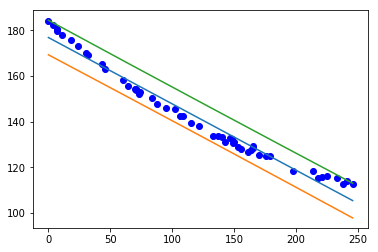

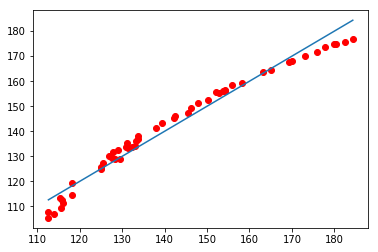

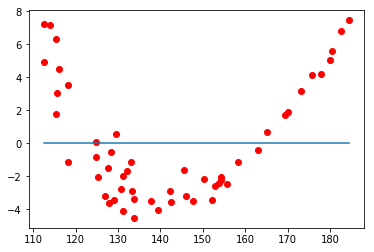

In [9]:
DrawRegression2DTest();

[-9.14239588  0.20454567]
391
0.8916411908474162


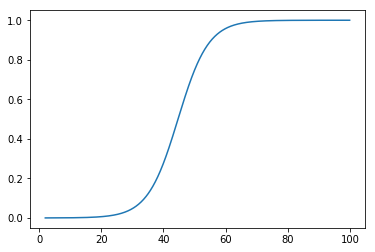

[[0.20274146]]
[-9.05758186]
[12]


array([[0.10975964, 0.89024036]])